# Prerequisites

In [64]:
pip install h3==3.7.7 h3pandas geodatasets

In [66]:
import pandas as pd
from geodatasets import get_path
from shapely.geometry import Point
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import h3
import h3pandas
from PIL import Image, ImageDraw, ImageFont, ImageOps
import requests

# Load Data

In [67]:
# Load data
df_tree = pd.read_csv('2015_Street_Tree_Census_-_Tree_Data_20250113.csv')

In [68]:
# Check columns
df_tree.columns

Index(['tree_id', 'block_id', 'created_at', 'tree_dbh', 'stump_diam',
       'curb_loc', 'status', 'health', 'spc_latin', 'spc_common', 'steward',
       'guards', 'sidewalk', 'user_type', 'problems', 'root_stone',
       'root_grate', 'root_other', 'trunk_wire', 'trnk_light', 'trnk_other',
       'brch_light', 'brch_shoe', 'brch_other', 'address', 'postcode',
       'zip_city', 'community board', 'borocode', 'borough', 'cncldist',
       'st_assem', 'st_senate', 'nta', 'nta_name', 'boro_ct', 'state',
       'latitude', 'longitude', 'x_sp', 'y_sp', 'council district',
       'census tract', 'bin', 'bbl'],
      dtype='object')

In [69]:
# Select columns
df_tree = df_tree[['tree_id', 'block_id', 'nta', 'nta_name', 'latitude', 'longitude']]
df_tree

tree_id  block_id   nta               nta_name   latitude  longitude
0        180683    348711  QN17           Forest Hills  40.723092 -73.844215
1        200540    315986  QN49             Whitestone  40.794111 -73.818679
2        204026    218365  BK90      East Williamsburg  40.717581 -73.936608
3        204337    217969  BK90      East Williamsburg  40.713537 -73.934456
4        189565    223043  BK37     Park Slope-Gowanus  40.666778 -73.975979
...         ...       ...   ...                    ...        ...        ...
683783   155433    217978  BK73  North Side-South Side  40.713211 -73.954944
683784   183795    348185  QN17           Forest Hills  40.715194 -73.856650
683785   166161    401670  SI07            Westerleigh  40.620762 -74.136517
683786   184028    504204  BX41             Mount Hope  40.850828 -73.903115
683787   200607    306527  QN41   Fresh Meadows-Utopia  40.732165 -73.787526

[683788 rows x 6 columns]

In [70]:
# Convert to GeoDataFrame
geometry = [Point(xy) for xy in zip(df_tree["longitude"], df_tree["latitude"])]
gdf_tree = gpd.GeoDataFrame(df_tree, geometry=geometry)

# Set a coordinate reference system (CRS), e.g., WGS84
gdf_tree.set_crs(epsg=4326, inplace=True)

# Display the resulting GeoDataFrame
gdf_tree

tree_id  block_id   nta               nta_name   latitude  longitude  \
0        180683    348711  QN17           Forest Hills  40.723092 -73.844215   
1        200540    315986  QN49             Whitestone  40.794111 -73.818679   
2        204026    218365  BK90      East Williamsburg  40.717581 -73.936608   
3        204337    217969  BK90      East Williamsburg  40.713537 -73.934456   
4        189565    223043  BK37     Park Slope-Gowanus  40.666778 -73.975979   
...         ...       ...   ...                    ...        ...        ...   
683783   155433    217978  BK73  North Side-South Side  40.713211 -73.954944   
683784   183795    348185  QN17           Forest Hills  40.715194 -73.856650   
683785   166161    401670  SI07            Westerleigh  40.620762 -74.136517   
683786   184028    504204  BX41             Mount Hope  40.850828 -73.903115   
683787   200607    306527  QN41   Fresh Meadows-Utopia  40.732165 -73.787526   

                          geometry  
0       POINT (-73.84422 40.72309)  
1       POINT (-73.81868 40.79411)  
2       POINT (-73.93661 40.71758)  
3       POINT (-73.93446 40.71354)  
4       POINT (-73.97598 40.66678)  
...                            ...  
683783  POINT (-73.95494 40.71321)  
683784  POINT (-73.85665 40.71519)  
683785  POINT (-74.13652 40.62076)  
683786  POINT (-73.90311 40.85083)  
683787  POINT (-73.78753 40.73217)  

[683788 rows x 7 columns]

<Axes: >

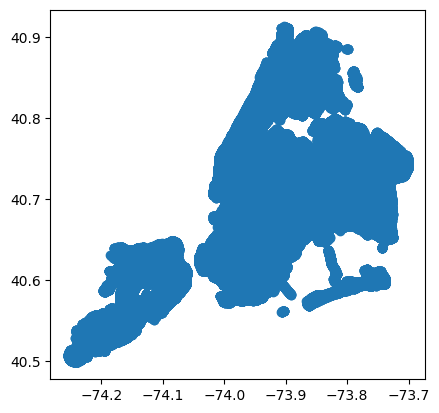

In [71]:
gdf_tree.plot()

BoroCode       BoroName     Shape_Leng    Shape_Area  \
0         5  Staten Island  330470.010332  1.623820e+09   
1         4         Queens  896344.047763  3.045213e+09   
2         3       Brooklyn  741080.523166  1.937479e+09   
3         1      Manhattan  359299.096471  6.364715e+08   
4         2          Bronx  464392.991824  1.186925e+09   

                                            geometry  
0  MULTIPOLYGON (((970217.022 145643.332, 970227....  
1  MULTIPOLYGON (((1029606.077 156073.814, 102957...  
2  MULTIPOLYGON (((1021176.479 151374.797, 102100...  
3  MULTIPOLYGON (((981219.056 188655.316, 980940....  
4  MULTIPOLYGON (((1012821.806 229228.265, 101278...

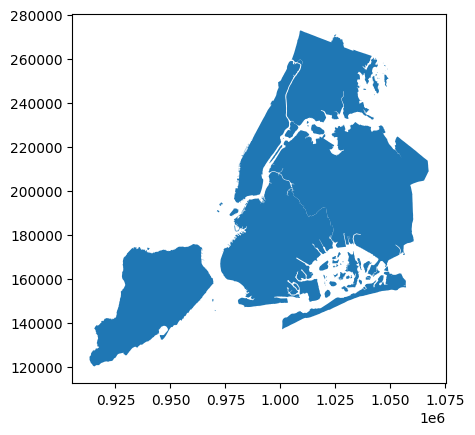

In [72]:
# Load the 'nybb' dataset using geodatasets
nybb_path = get_path("nybb")
nybb = gpd.read_file(nybb_path)
nybb.plot()

# Display data
nybb

In [73]:
# Check CRS
print(nybb.crs)

# If CRS is missing, set it (assuming WGS84 if not defined)
nybb = nybb.to_crs(epsg=4326)  # WGS84 (latitude/longitude)

print(nybb.crs)


EPSG:2263
EPSG:4326


# Build Hex

<Axes: >

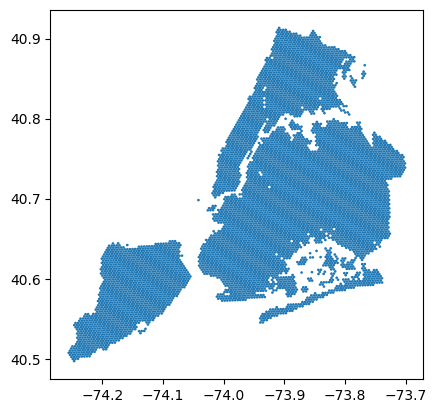

In [80]:
# Build hex
resolution = 9
hexagons = nybb.h3.polyfill_resample(resolution)
hexagons.plot()

In [81]:
# Ensure both GeoDataFrames have the same CRS
gdf_tree = gdf_tree.to_crs(hexagons.crs)

# Perform spatial join: match points in `gdf_tree` to hexagons in `hexagons`
joined = gpd.sjoin(gdf_tree, hexagons, how="inner")

# Count the number of points in each hexagon
hex_counts = joined.groupby("h3_polyfill").size().reset_index(name="point_count")

# Merge the count data back into the `hexagons` GeoDataFrame
hexagons["point_count"] = hexagons.index.map(hex_counts.set_index("h3_polyfill")["point_count"])

# Replace NaN with 0 for hexagons with no points
hexagons["point_count"] = hexagons["point_count"].fillna(0)


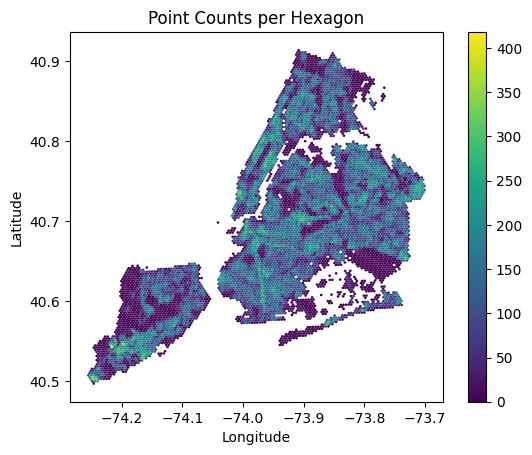

In [82]:
# Plot the hexagons with point counts
hexagons.plot(column="point_count", cmap="viridis", legend=True)
plt.title("Point Counts per Hexagon")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

# Tidy Up Viz

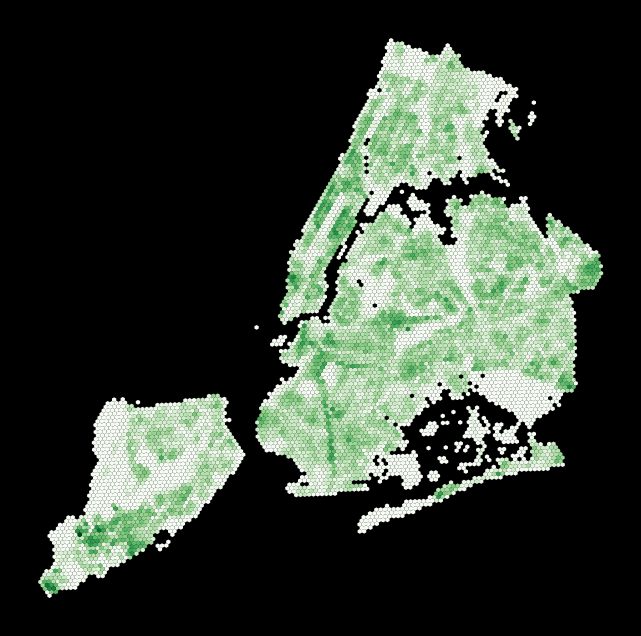

In [83]:
# Plot the hexagons with a green color scheme, black background, and no axes
fig, ax = plt.subplots(figsize=(10, 8), facecolor='black')

# Plot the hexagons without the legend
hexagons.plot(
    column="point_count",
    cmap="Greens",
    legend=False,
    ax=ax,
    edgecolor="none"
)

# Customize the plot
ax.set_facecolor("black")  # Set the background color to black
ax.axis("off")  # Remove axes

# Save the plot as a PNG file
filename = "street_trees_nyc_hexagons.png"
plt.savefig(filename, dpi=300, bbox_inches='tight', facecolor='black')

plt.show()

In [84]:
# Download the fonts
title_font_url = "https://github.com/google/fonts/raw/main/ofl/merriweather/Merriweather-Regular.ttf"
footer_font_url = "https://github.com/google/fonts/raw/main/ofl/lato/Lato-Regular.ttf"
title_font_path = "TitleFont-Regular.ttf"
footer_font_path = "FooterFont-Regular.ttf"

# Download Title Font
with open(title_font_path, "wb") as file:
    file.write(requests.get(title_font_url).content)

# Download Footer Font
with open(footer_font_path, "wb") as file:
    file.write(requests.get(footer_font_url).content)

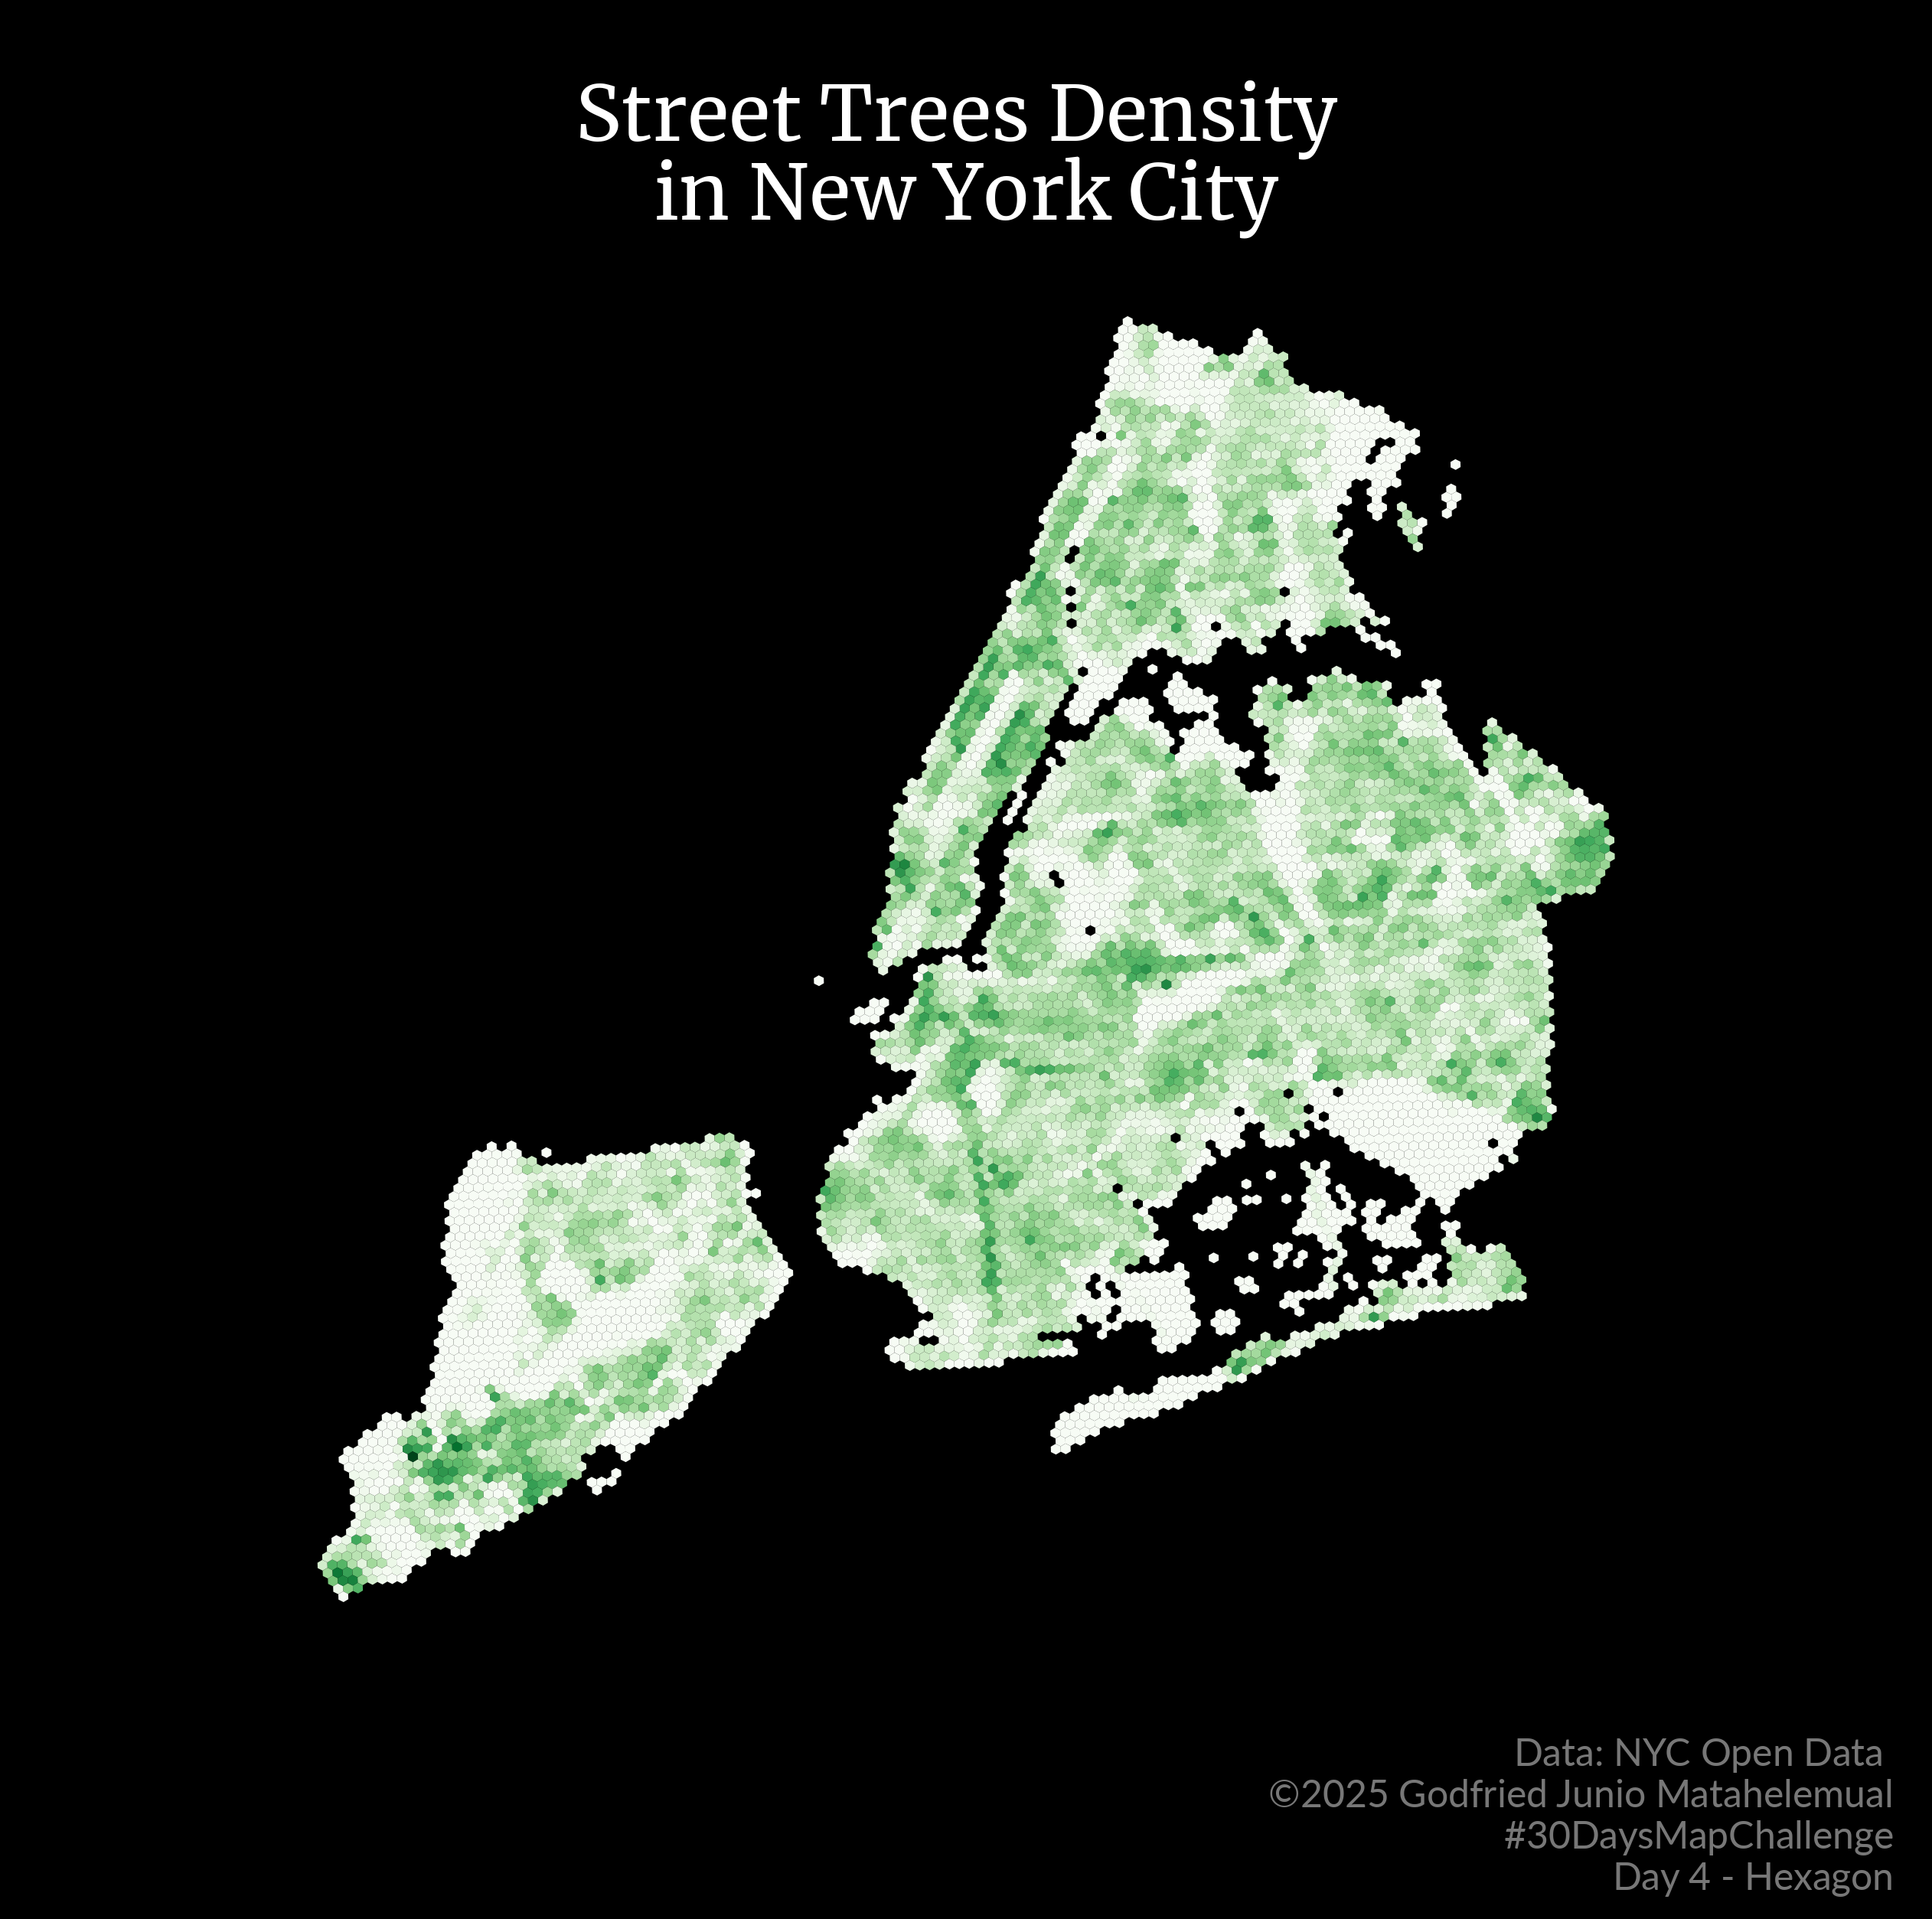

In [87]:
# Load the exported map image
map_image = Image.open(filename)

# Add padding to the image
padding = (300, 300, 300, 300)  # (left, top, right, bottom)
padded_image = ImageOps.expand(map_image, border=padding, fill="black")

# Create a drawing context
draw = ImageDraw.Draw(padded_image)

# Load fonts
title_font = ImageFont.truetype(title_font_path, size=100)
footer_font = ImageFont.truetype(footer_font_path, size=50)

# Add title
title_text = "Street Trees Density \nin New York City"
title_position = (padded_image.width // 2, 200)  # Centered in the top padding
draw.multiline_text(
    title_position,
    title_text,
    font=title_font,
    fill="white",
    anchor="mm",
    align="center",
)

# Add footer
footer_text = "Data: NYC Open Data \n©2025 Godfried Junio Matahelemual\n#30DaysMapChallenge\nDay 4 - Hexagon"
footer_position = (padded_image.width - 50, padded_image.height - 250)
draw.multiline_text(
    footer_position,
    footer_text,
    font=footer_font,
    fill="#777777",  # gray
    anchor="ra",  # Right-aligned
    align="right",
)

# Save the final annotated image
output_filename = f"finalmap_{filename}"
padded_image.save(output_filename)

# Display result
padded_image
